<h2>1. IMPORT NECESSARY LIBRARIES</h2>

In [746]:
import numpy as np 
import pandas as pd
import random

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
%matplotlib inline


from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.cluster import KMeans

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping

<h2>2. READ THE FILE AND CLEAN IT UP</h2>

In [747]:
#messy data file

df = pd.DataFrame(columns = range(25))

file = open('/Users/mahima.sharma/Downloads/Chronic_Kidney_Disease/chronic_kidney_disease.arff')
line_list = file.readlines()

columns_list = []
index = 0

for line in line_list:
    
    #remove all leading and trailing whitespaces
    line =  line.strip()
    
    #process column names from the file and put into a list
    if(line[0:10] == '@attribute'):
        line_split = line.split()
        columns_list.append(line_split[1][1:len(line_split[1]) - 1])
        
    #process records from the file  
    else:
        line = line.replace('\t', '')
        line = line.replace(' ', '')
        line_split = line.split(',')
        
        #edge case records with multiple extra commas 
        if(len(line_split) != 25):
            for val in line_split:
                if val == '':
                    line_split.remove(val)

        if len(line_split) == 25:
            df.loc[index] = line_split
            index += 1

In [748]:
df.columns = columns_list

<h3>3. PRELIMINARY DATA EXPLORATION OF DATASET</h3>

In [749]:
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48,80,1.020,1,0,?,normal,notpresent,notpresent,121,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7,50,1.020,4,0,?,normal,notpresent,notpresent,?,...,38,6000,?,no,no,no,good,no,no,ckd
2,62,80,1.010,2,3,normal,normal,notpresent,notpresent,423,...,31,7500,?,no,yes,no,poor,no,yes,ckd
3,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [750]:
df.shape

(400, 25)

> The dataset has 400 rows and 25 columns (24 attributes + 1 target class)

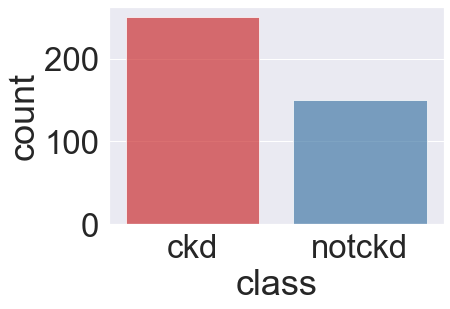

In [751]:
sns.countplot(df['class'], palette = 'Set1', alpha = 0.7)

In [752]:
df = df.replace('?', np.nan)

In [753]:
df.isnull().sum()

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

>The number of missing values in each column

In [754]:
100 * df.isnull().sum()/len(df)

age       2.25
bp        3.00
sg       11.75
al       11.50
su       12.25
rbc      38.00
pc       16.25
pcc       1.00
ba        1.00
bgr      11.00
bu        4.75
sc        4.25
sod      21.75
pot      22.00
hemo     13.00
pcv      17.75
wbcc     26.50
rbcc     32.75
htn       0.50
dm        0.50
cad       0.50
appet     0.25
pe        0.25
ane       0.25
class     0.00
dtype: float64

>Percent of missing values in column

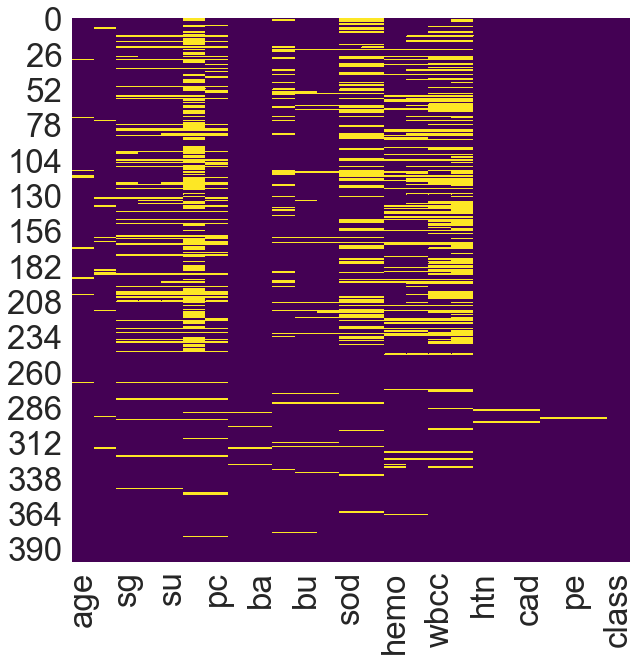

In [755]:
plt.figure(figsize = (10,10))
sns.heatmap(df.isnull(), cbar=False, cmap = 'viridis')

>Yellow blue parts are missing values. We can see that rbc and rbcc are missing the most values

In [756]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   age     391 non-null    object
 1   bp      388 non-null    object
 2   sg      353 non-null    object
 3   al      354 non-null    object
 4   su      351 non-null    object
 5   rbc     248 non-null    object
 6   pc      335 non-null    object
 7   pcc     396 non-null    object
 8   ba      396 non-null    object
 9   bgr     356 non-null    object
 10  bu      381 non-null    object
 11  sc      383 non-null    object
 12  sod     313 non-null    object
 13  pot     312 non-null    object
 14  hemo    348 non-null    object
 15  pcv     329 non-null    object
 16  wbcc    294 non-null    object
 17  rbcc    269 non-null    object
 18  htn     398 non-null    object
 19  dm      398 non-null    object
 20  cad     398 non-null    object
 21  appet   399 non-null    object
 22  pe      399 non-null    ob

In [757]:
#Split data right away to avoid potential data leakage while scaling etc

from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.33, random_state=101, shuffle = True)

df_train.reset_index(inplace = True)
df_train = df_train.drop('index', axis = 1)

df_test.reset_index(inplace = True)
df_test = df_test.drop('index', axis = 1)

In [758]:
df_train['class'].value_counts()

ckd       160
notckd    108
Name: class, dtype: int64

In [759]:
df_test['class'].value_counts()

ckd       90
notckd    42
Name: class, dtype: int64

<h3>DATA EXPLORATION OF TRAINING DATASET</h3>

In [760]:
df_train.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,35,80,1.020,0,0,normal,normal,notpresent,notpresent,104,...,45,4300,5.2,no,no,no,good,no,no,notckd
1,63,100,1.010,2,2,normal,normal,notpresent,present,280,...,40,9800,4.2,yes,no,yes,good,no,no,ckd
2,70,60,NaN,NaN,NaN,NaN,NaN,notpresent,notpresent,120,...,43,4500,4.9,no,no,no,good,no,no,notckd
3,64,70,1.020,0,0,normal,normal,notpresent,notpresent,97,...,49,6400,4.8,no,no,no,good,no,no,notckd
4,70,80,NaN,NaN,NaN,NaN,NaN,notpresent,notpresent,158,...,30,NaN,NaN,yes,no,no,good,yes,no,ckd


In [761]:
df_train.shape

(268, 25)

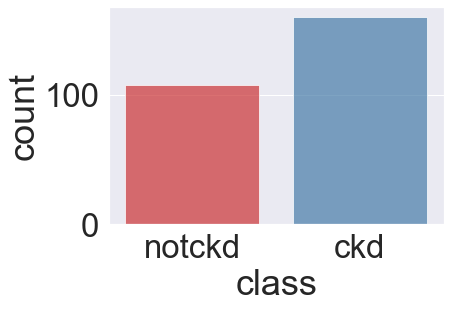

In [762]:
sns.countplot(df_train['class'], palette = 'Set1', alpha = 0.7)

In [763]:
df_train = df_train.replace('?', np.nan)

In [764]:
df_train.isnull().sum()

age       6
bp        7
sg       30
al       29
su       31
rbc      98
pc       40
pcc       3
ba        3
bgr      27
bu       13
sc       11
sod      53
pot      54
hemo     29
pcv      38
wbcc     64
rbcc     79
htn       2
dm        2
cad       2
appet     1
pe        1
ane       1
class     0
dtype: int64

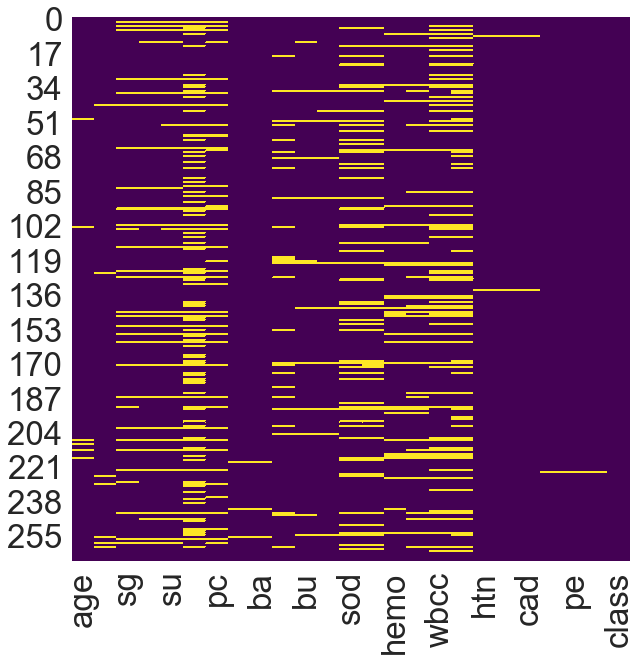

In [765]:
plt.figure(figsize = (10,10))
sns.heatmap(df_train.isnull(), cbar=False, cmap = 'viridis')

<h3>3A. EXPLORATION OF NUMERICAL ATTRIBUTES</h3>

In [766]:
df_train.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
       'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'class'],
      dtype='object')

In [767]:
numeric_columns = ['age','bp', 'bgr','bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']

for column in numeric_columns:
    df_train[column] = pd.to_numeric(df_train[column], errors = 'ignore')

In [768]:
df_train['class'] = df_train['class'].map({'ckd' : 0, 'notckd' : 1})

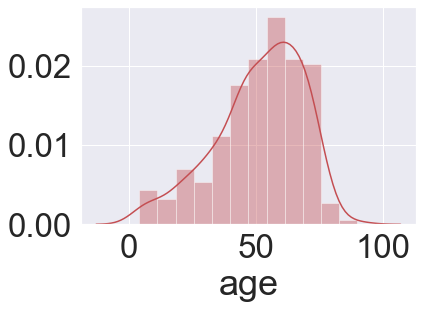

In [769]:
sns.distplot(df_train['age'], color = 'r')

>We can see that the age distributation is a bit skewed towards older ages

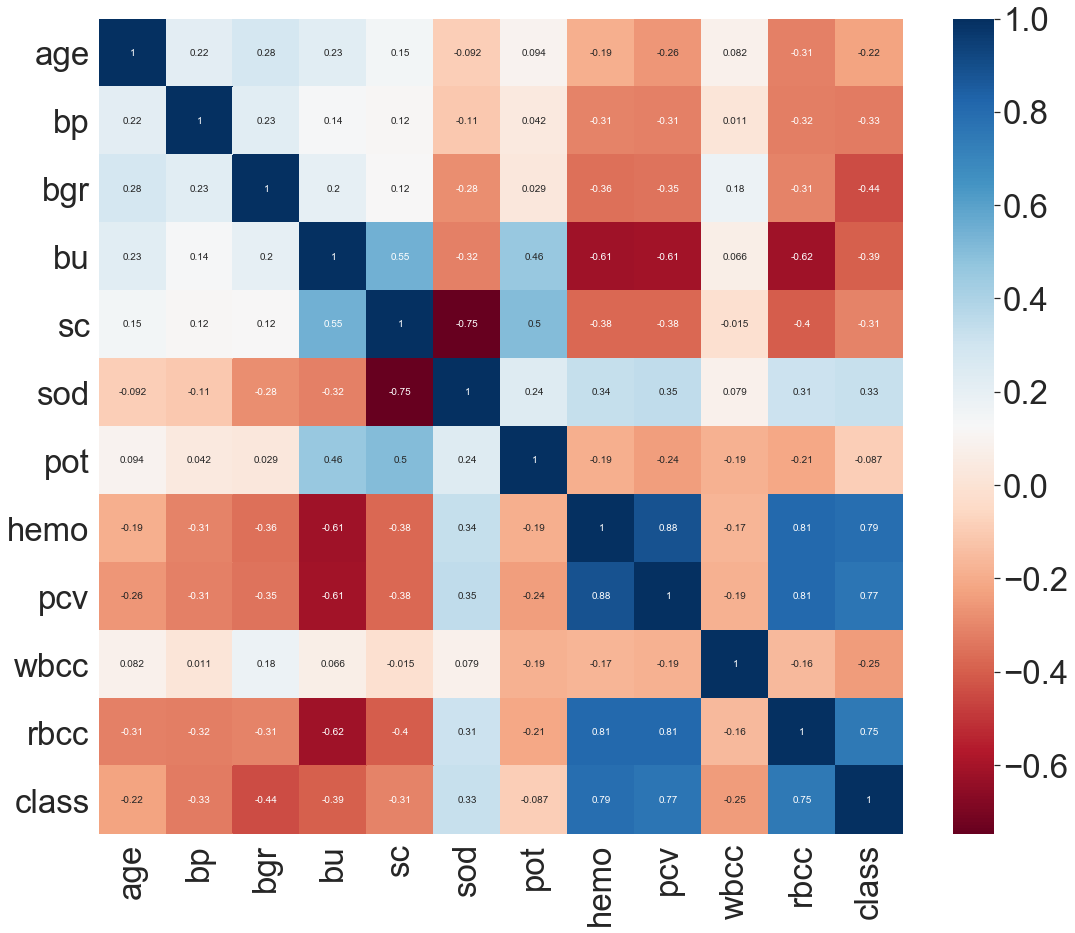

In [770]:
plt.figure(figsize = (18,15))
sns.heatmap(df_train.corr(), annot = True, cmap = 'RdBu')

>We can see strong positive corrolation between: 

    target class and hemo 
    target class and pcv
    target class and rbcc
    rbcc and hemo
    rbcc and pcv
    pcv and hemo

>We can see a strong negative corrolation between: 

    sod and sc
    hemo and bu
    pcv and bu
    rbcc and bu

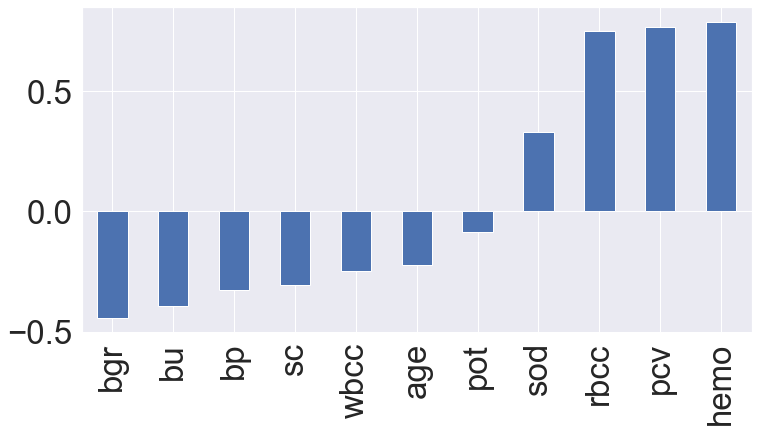

In [771]:
plt.figure(figsize = (12,6))
df_train.corr()['class'][:-1].sort_values().plot(kind = 'bar')

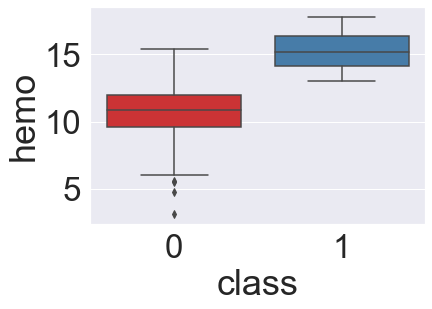

In [772]:
fig = plt.figure(figsize = (6,4))
sns.boxplot(x = 'class', y = 'hemo', data=df_train, palette = 'Set1')

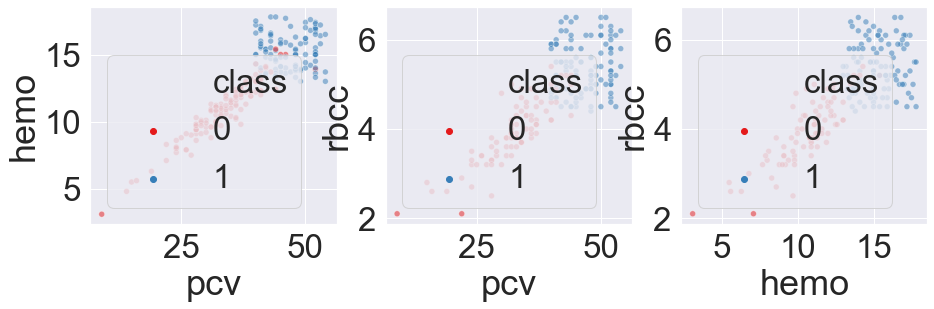

In [773]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15,4))
sns.scatterplot(x = 'pcv', y = 'hemo', data=df_train, palette = 'Set1', hue = 'class', ax = axes[0], alpha = 0.5)
sns.scatterplot(x = 'pcv', y = 'rbcc', data=df_train, palette = 'Set1', hue = 'class', ax = axes[1], alpha = 0.5)
sns.scatterplot(x = 'hemo', y = 'rbcc', data=df_train, palette = 'Set1', hue = 'class', ax = axes[2], alpha = 0.5)

>Hemo, pcv and rbcc are strong predictors of the target class. However, in the previous heat map, they seem highly corrolated with one another too. We can probably drop two of them later on. Lets check for more distinction in a 3D plot

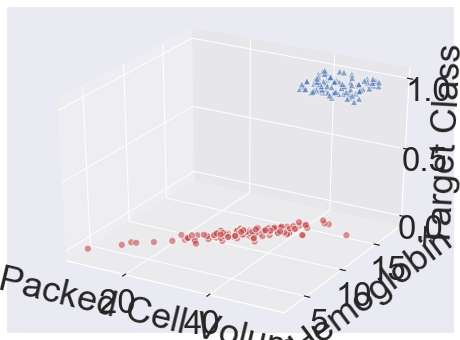

In [774]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

xs1= df_train[df_train['class'] == 0]['pcv']
xs2 = df_train[df_train['class'] == 1]['pcv']
ys1 = df_train[df_train['class'] == 0]['hemo']
ys2= df_train[df_train['class'] == 1]['hemo']
zs1 = df_train[df_train['class'] == 0]['class']
zs2 = df_train[df_train['class'] == 1]['class']
ax.scatter(xs1, ys1, zs1, s=50, alpha=0.6, edgecolors='w', c = 'r', marker = 'o')
ax.scatter(xs2, ys2, zs2, s=50, alpha=0.6, edgecolors='w', c = 'b', marker = '^')
ax.set_xlabel('Packed Cell Volume')
ax.set_ylabel('Hemoglobin')
ax.set_zlabel('Target Class')

plt.show()


>The clusters between the two target classes can be easily observed here

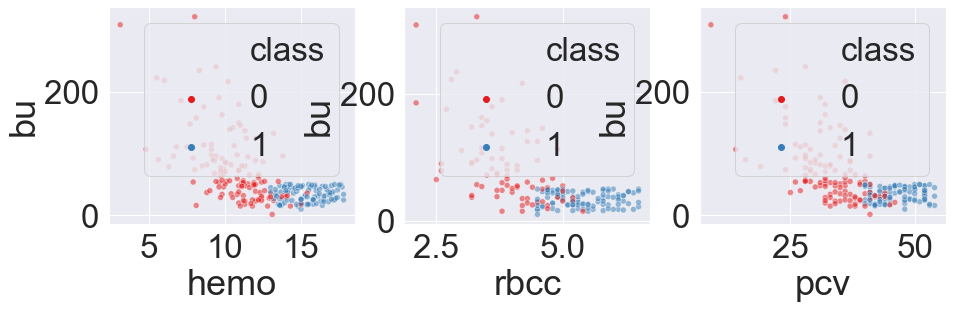

In [775]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15,4))
sns.scatterplot(x = 'hemo', y = 'bu', data=df_train, palette = 'Set1', hue = 'class', ax = axes[0], alpha = 0.5)
sns.scatterplot(x = 'rbcc', y = 'bu', data=df_train, palette = 'Set1', hue = 'class', ax = axes[1], alpha = 0.5)
sns.scatterplot(x = 'pcv', y = 'bu', data=df_train, palette = 'Set1', hue = 'class', ax = axes[2], alpha = 0.5)

>bu is also a strong predictor of the target class. Lets check for more distinctions in a 3D plot

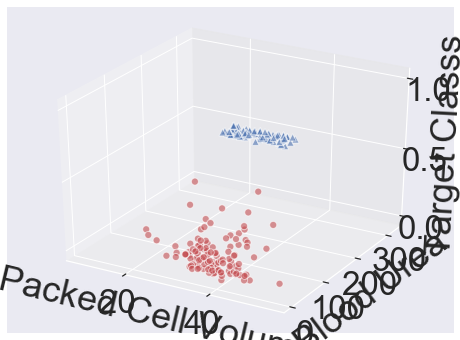

In [776]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

xs1= df_train[df_train['class'] == 0]['pcv']
xs2 = df_train[df_train['class'] == 1]['pcv']
ys1 = df_train[df_train['class'] == 0]['bu']
ys2= df_train[df_train['class'] == 1]['bu']
zs1 = df_train[df_train['class'] == 0]['class']
zs2 = df_train[df_train['class'] == 1]['class']
ax.scatter(xs1, ys1, zs1, s=50, alpha=0.6, edgecolors='w', c = 'r', marker = 'o')
ax.scatter(xs2, ys2, zs2, s=50, alpha=0.6, edgecolors='w', c = 'b', marker = '^')

ax.set_xlabel('Packed Cell Volume')
ax.set_ylabel('Blood Urea')
ax.set_zlabel('Target Classs')

plt.show()


In [777]:
skewness_attributes = display(df_train.select_dtypes("number").skew().sort_values(ascending=False))
print(skewness_attributes)

pot      12.483342
sc        7.019546
bu        2.784046
bgr       1.993512
bp        1.886397
wbcc      1.099511
class     0.397807
rbcc     -0.331404
hemo     -0.349931
pcv      -0.445771
age      -0.687475
sod      -7.391597
dtype: float64

None


>'pot' attribute has a high level of skewness. Let us explore this further

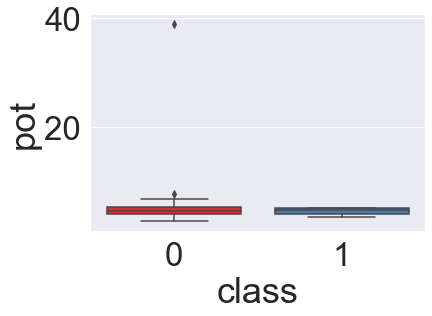

In [778]:
sns.boxplot(x = 'class', y = 'pot', data=df_train, palette = 'Set1')

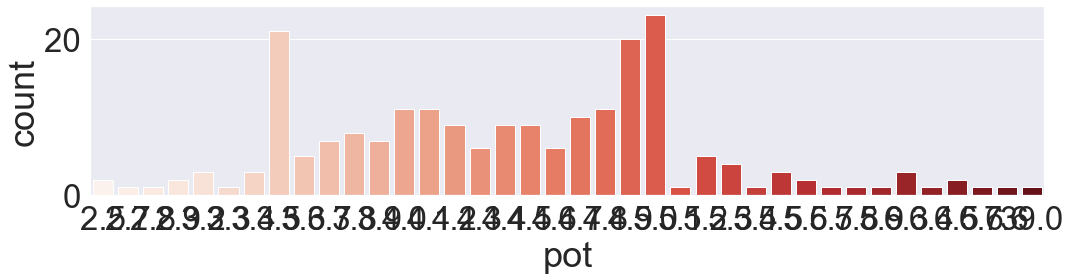

In [779]:
plt.figure(figsize = (15,4))
sns.countplot(x = 'pot', data = df_train, palette = 'Reds')
plt.tight_layout()

>These two plots indicate the prescence of an outlier at 39.0. We will tackle this later

3b. EXPLORATION OF NOMINAL ATTRIBUTES

>First we will explore the ordinal attributes

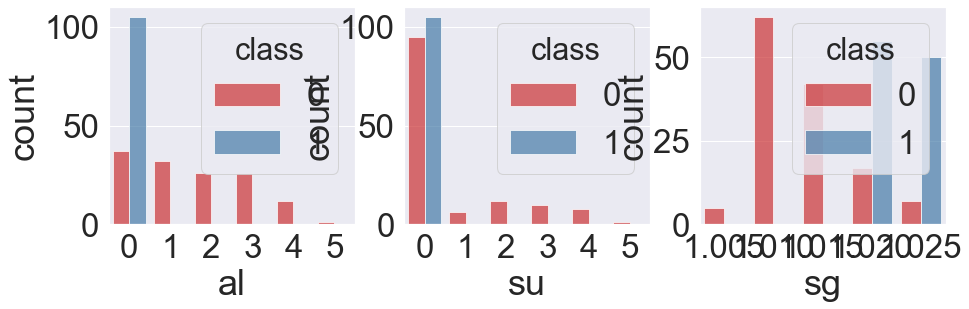

In [780]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15,4))
order_al = ['0','1','2','3','4', '5']
order_sg = ['1.005','1.010','1.015','1.020','1.025']
sns.countplot(x='al', data=df_train, hue = 'class', order = order_al, ax = axes[0], palette = 'Set1', alpha = 0.7)
sns.countplot(x='su', data=df_train, hue = 'class', order = order_al, ax = axes[1], palette = 'Set1', alpha = 0.7)
sns.countplot(x='sg', data=df_train, hue = 'class', order = order_sg, ax = axes[2], palette = 'Set1', alpha = 0.7)

>Those without kidney diseases are limited to fewer categories

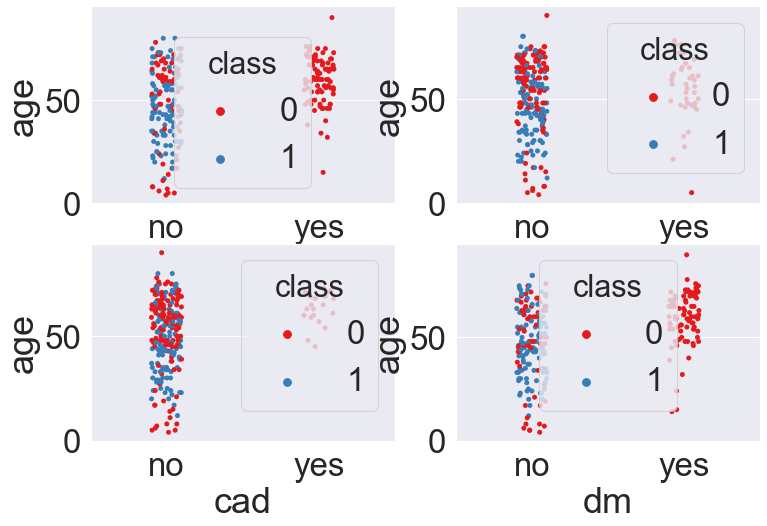

In [781]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (12,8))
order_nom = ['no', 'yes']
sns.stripplot(x='htn', y = 'age', data=df_train, hue = 'class',order = order_nom, palette = 'Set1', ax = axes[0][0])
sns.stripplot(x='ane', y = 'age', data=df_train, hue = 'class', order = order_nom, palette = 'Set1', ax = axes[0][1])
sns.stripplot(x='cad', y = 'age', data=df_train, hue = 'class', order = order_nom, palette = 'Set1', ax = axes[1][0])
sns.stripplot(x='dm', y = 'age', data=df_train, hue = 'class', order = order_nom, palette = 'Set1', ax = axes[1][1])

>This graph represents corollations of chronic kidney disease with other health problems like hypertension (htn), anemia (ane), coronary artery disease (cad), and diabetes (dm)

>Those without kidney disease said that they don't have any of these diseases as well 

<h2>4. PREPROCESSING</h2>

<h3>4A. NOISE AND OUTLIER HANDLING</h3>

<h4>a. Pottasium </h4>

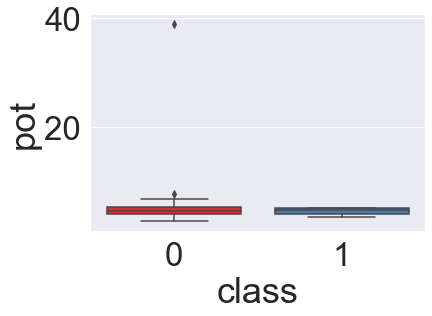

In [782]:
sns.boxplot(x = 'class', y = 'pot', data=df_train, palette = 'Set1')

In [783]:
df_train[df_train['pot'] > 30]

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
138,67.0,80.0,1.010,1,3,normal,abnormal,notpresent,notpresent,182.0,...,NaN,NaN,NaN,no,no,no,good,yes,no,0


In [784]:
#Noise
df_train.iloc[138,13] = df_train['pot'].median()

<h4>b. Serum Creatinine</h4>

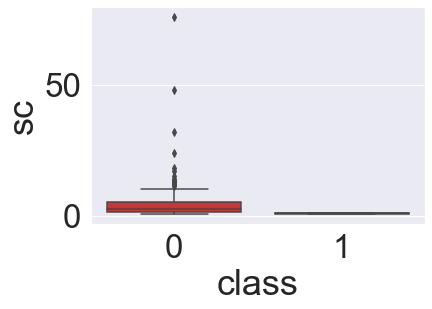

In [785]:
sns.boxplot(x = 'class', y = 'sc', data=df_train, palette = 'Set1')

In [786]:
df_train[df_train['sc'] > 15]

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
12,47.0,100.0,1.010,NaN,NaN,normal,NaN,notpresent,notpresent,122.0,...,33.0,10200.0,3.8,no,yes,no,good,no,no,0
102,69.0,60.0,NaN,NaN,NaN,NaN,NaN,notpresent,notpresent,171.0,...,NaN,NaN,NaN,yes,no,no,poor,no,no,0
108,68.0,70.0,1.010,0,0,NaN,normal,notpresent,notpresent,100.0,...,36.0,NaN,NaN,no,no,no,good,no,no,0
118,32.0,90.0,1.025,1,0,abnormal,abnormal,notpresent,notpresent,NaN,...,15.0,2600.0,2.8,yes,yes,no,poor,yes,yes,0
138,67.0,80.0,1.010,1,3,normal,abnormal,notpresent,notpresent,182.0,...,NaN,NaN,NaN,no,no,no,good,yes,no,0
171,60.0,90.0,NaN,NaN,NaN,NaN,NaN,notpresent,notpresent,NaN,...,32.0,6200.0,3.6,yes,yes,yes,good,no,no,0


In [787]:
#Noise
df_train.iloc[171,11] = df_train['sc'].median()
df_train.iloc[138,11] = df_train['sc'].median()
df_train.iloc[118,11] = df_train['sc'].median()
df_train.iloc[108,11] = df_train['sc'].median()
df_train.iloc[102,11] = df_train['sc'].median()
df_train.iloc[12,11] = df_train['sc'].median()

<h4>c. Sodium</h4>

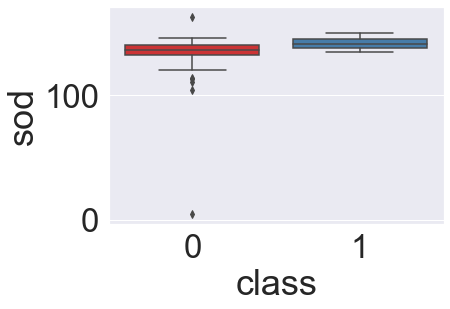

In [788]:
sns.boxplot(x = 'class', y = 'sod', data=df_train, palette = 'Set1')

In [789]:
df_train[df_train['sod'] < 10]

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
171,60.0,90.0,NaN,NaN,NaN,NaN,NaN,notpresent,notpresent,NaN,...,32.0,6200.0,3.6,yes,yes,yes,good,no,no,0


In [790]:
#Noise
df_train.iloc[171,12] = df_train['sod'].median()

<h4>d. Packed Cell Volume</h4>

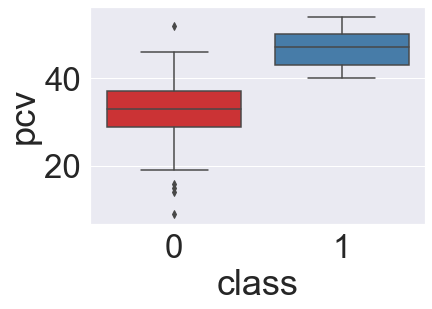

In [791]:
sns.boxplot(x = 'class', y = 'pcv', data=df_train, palette = 'Set1')

In [792]:
df_train[df_train['pcv'] < 10]

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
241,56.0,90.0,1.010,4,1,normal,abnormal,present,notpresent,176.0,...,9.0,5400.0,2.1,yes,yes,no,poor,yes,yes,0


In [793]:
df_train.iloc[241,15] = df_train['pcv'].median()

<h3>4B. ENCODING CATEGORICAL VARIABLES</h3>

In [794]:
categorical_columns = ['sg','al','su']

for column in categorical_columns:
    df_train[column] = pd.to_numeric(df_train[column], errors = 'ignore')

In [795]:
df_train.select_dtypes(exclude = np.number).columns

Index(['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane'], dtype='object')

In [796]:
df_train['rbc'] = df_train['rbc'].map({'normal' : 0, 'abnormal' : 1})
df_train['pc'] = df_train['pc'].map({'normal' : 0, 'abnormal' : 1})
df_train['pcc'] = df_train['pcc'].map({'notpresent' : 0, 'present' : 1})
df_train['ba'] = df_train['ba'].map({'notpresent' : 0, 'present' : 1})
df_train['htn'] = df_train['htn'].map({'no' : 0, 'yes' : 1})
df_train['dm'] = df_train['dm'].map({'no' : 0, 'yes' : 1})
df_train['cad'] = df_train['cad'].map({'no' : 0, 'yes' : 1})
df_train['pe'] = df_train['pe'].map({'no' : 0, 'yes' : 1})
df_train['ane'] = df_train['ane'].map({'no' : 0, 'yes' : 1})
df_train['appet'] = df_train['appet'].map({'good' : 0, 'poor' : 1})

In [797]:
numeric_columns = ['age','bp', 'bgr','bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']

for column in numeric_columns:
    df_test[column] = pd.to_numeric(df_test[column], errors = 'ignore')


categorical_columns = ['sg','al','su']

for column in categorical_columns:
    df_test[column] = pd.to_numeric(df_test[column], errors = 'ignore')

In [798]:
df_test['rbc'] = df_test['rbc'].map({'normal' : 0, 'abnormal' : 1})
df_test['pc'] = df_test['pc'].map({'normal' : 0, 'abnormal' : 1})
df_test['pcc'] = df_test['pcc'].map({'notpresent' : 0, 'present' : 1})
df_test['ba'] = df_test['ba'].map({'notpresent' : 0, 'present' : 1})
df_test['htn'] = df_test['htn'].map({'no' : 0, 'yes' : 1})
df_test['dm'] = df_test['dm'].map({'no' : 0, 'yes' : 1})
df_test['cad'] = df_test['cad'].map({'no' : 0, 'yes' : 1})
df_test['pe'] = df_test['pe'].map({'no' : 0, 'yes' : 1})
df_test['ane'] = df_test['ane'].map({'no' : 0, 'yes' : 1})
df_test['appet'] = df_test['appet'].map({'good' : 0, 'poor' : 1})
df_test['class'] = df_test['class'].map({'ckd' : 0, 'notckd' : 1})

<h3>4C. SCALING AND IMPUTATION OF MISSING DATA</h3>

In [799]:
X_train = df_train.drop('class', axis = 1)
y_train = df_train['class']

X_test = df_test.drop('class', axis = 1)
y_test = df_test['class']


In [800]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [801]:
X_train = pd.DataFrame(X_train, columns = df_train.columns[0:24])
X_test = pd.DataFrame(X_test, columns = df_test.columns[0:24])

mean_cols = ['age','bp','bgr','bu','sc','sod','pot','hemo','pcv','wbcc','rbcc']

for col in mean_cols:
    mean = X_train[col].mean()
    X_train[col] = X_train[col].fillna(mean)
    X_test[col] = X_test[col].fillna(mean)
    
mode_cols = ['sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']

for col in mode_cols:
    mode = X_train[col].mode()
    X_train[col]=X_train[col].fillna(value = mode[0])
    X_test[col]=X_test[col].fillna(value = mode[0])

<h3>4D. FEATURE SELECTION</h3>

>Feature Selection is the process of selecting features which contribute most to the prediction variable

In [802]:
X_train = pd.DataFrame(X_train, columns = df_train.columns[0:24])
X_test = pd.DataFrame(X_test, columns = df_test.columns[0:24])

In [803]:
#Unscaled Copy needed in physician step in clustering 

X_train_copy = pd.DataFrame(scaler.inverse_transform(X_train), columns = X_train.columns)
X_test_copy = pd.DataFrame(scaler.inverse_transform(X_test), columns = X_test.columns)

In [804]:
X_train_copy = X_train_copy.round(3)
X_test_copy = X_test_copy.round(3)

In [805]:
#Drop features whose correlation with one another is more than 0.8 because they provide duplicate information
#hemo and pcv correlation - 0.87
#hemo and rbcc correlation - 0.81
X_train = X_train.drop(['pcv','rbcc'], axis = 1)
X_test = X_test.drop(['pcv','rbcc'], axis = 1)

<h4>1. Recursive Feature Elimination (Wrapper Method)</h4>

>Works by removing attributes recursively and building a model from the features that remain.

In [806]:
model = RandomForestClassifier()
#SVM also selects same features
rfe = RFE(model,8)
X_train_rfe = rfe.fit_transform(X_train, y_train)

model.fit(X_train_rfe, y_train)
score = model.score(X_train_rfe,y_train)
print('score', score)
temp = pd.Series(rfe.support_, index = X_train.columns)
selected_features_rfe = temp[temp == True].index

score 1.0


In [807]:
selected_features_rfe

Index(['sg', 'al', 'bgr', 'bu', 'sc', 'hemo', 'htn', 'dm'], dtype='object')

<h4>2. Lasso Regularization (Embedded Method)</h4>

>At each iteration, the features which contribute the most are selected


>Regularization methods are the most commonly used embedded methods which penalize a feature given a coefficient threshold

In [808]:
reg = LassoCV()
reg.fit(X_train, y_train)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X_train,y_train))
selected_features_lasso = pd.Series(reg.coef_, index = X_train.columns)

Best alpha using built-in LassoCV: 0.005265
Best score using built-in LassoCV: 0.731181


In [809]:
print("Lasso picked " + str(sum(selected_features_lasso != 0)) + " variables and eliminated the other " +  str(sum(selected_features_lasso == 0)) + " variables")

Lasso picked 6 variables and eliminated the other 16 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

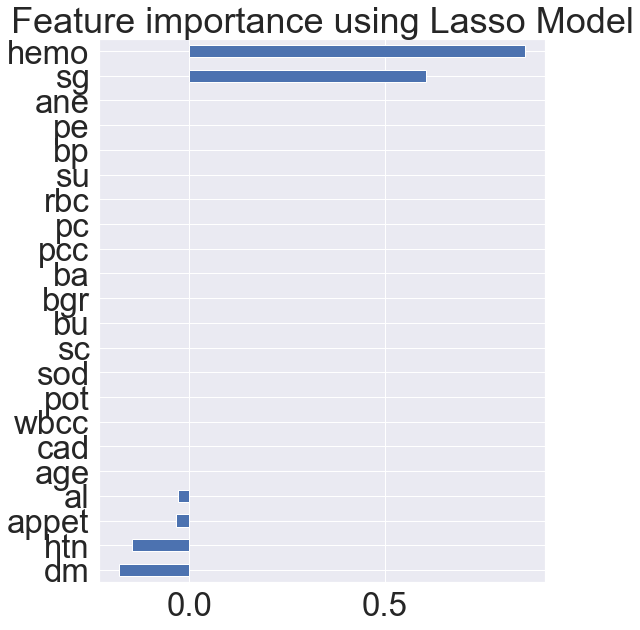

In [810]:
selected_features_lasso = selected_features_lasso.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
selected_features_lasso.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

<h4>3. Pearson's Corrolation (Filter Based Method)</h4>

In [811]:
pearsons_df_x = pd.DataFrame(X_train, columns = X_train.columns)
pearsons_df_y = pd.DataFrame(y_train)
pearsons_df = pd.concat([pearsons_df_x, pearsons_df_y], axis = 1)

In [812]:
pearsons_df = pearsons_df.corr()['class'][0:24].abs().sort_values(ascending = False)[1:9]

In [813]:
pearsons_df

hemo    0.752760
sg      0.680590
dm      0.598928
htn     0.594004
al      0.529970
sc      0.453753
bgr     0.424698
sod     0.409018
Name: class, dtype: float64

>According to these three feature selection methods, the top 8 attributes are : 
['hemo', 'sg', 'al', 'bgr', 'htn', 'dm', 'appet', 'sc']

In [814]:
to_keep_cols = ['hemo', 'sg', 'al', 'bgr', 'htn', 'dm', 'appet','sc', 'age']

X_tr_cluster= X_train.copy()

for col in X_train.columns:
    if col not in to_keep_cols:
        X_train = X_train.drop(col, axis = 1)
        X_test = X_test.drop(col, axis = 1)

        
X_tr_cluster= X_train.copy()
X_train = X_train.drop('age', axis = 1)
X_te_cluster = X_test.copy()
X_test = X_test.drop('age', axis = 1)

<h2>5. MACHINE LEARNING MODELS:</h2>

<h3>5A. DECISION TREE:</h3>

In [815]:

dt = DecisionTreeClassifier(random_state = 1)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
print(confusion_matrix(y_test, dt_pred))
print(classification_report(y_test, dt_pred))


[[88  2]
 [ 2 40]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        90
           1       0.95      0.95      0.95        42

    accuracy                           0.97       132
   macro avg       0.97      0.97      0.97       132
weighted avg       0.97      0.97      0.97       132



In [816]:
#plt.figure(figsize = (10,8))
#tree.plot_tree(dt, feature_names = X_train.columns, class_names = ['ckd', 'notckd'], filled = True, rounded = True)

In [817]:
# parameters={'min_samples_split' : range(2,20,1),'max_depth': range(1,20,1), 'criterion' : ['gini', 'entropy'], 'min_samples_leaf' : [2,8,1], 'random_state' : [1]}
# grid=GridSearchCV(dt,parameters, verbose = 3, cv = 5)
# grid.fit(X_train,y_train)
# print(grid.best_estimator_)
# print(grid.best_params_)
# y_pred = grid.predict(X_test)
# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred)) 

Hyperparameter tuning did not change the performance of the model

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        90
           1       0.95      0.95      0.95        42

    accuracy                           0.97       132
   macro avg       0.97      0.97      0.97       132
weighted avg       0.97      0.97      0.97       132



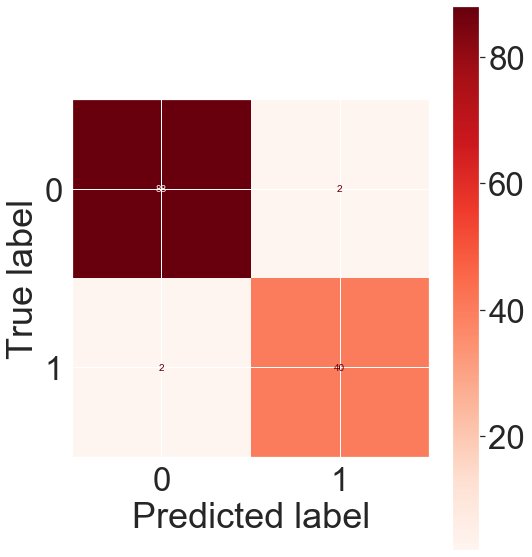

In [818]:
dt = DecisionTreeClassifier(criterion = 'gini', max_depth = 4, min_samples_leaf = 1, min_samples_split = 2,random_state = 1)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
#sns.set(font_scale=3.0)
disp = plot_confusion_matrix(dt, X_test, y_test,cmap= plt.cm.Reds)
print(classification_report(y_test, dt_pred))


[Text(223.2, 391.392, 'hemo <= 0.69\ngini = 0.481\nsamples = 268\nvalue = [160, 108]\nclass = ckd'), Text(133.92000000000002, 304.416, 'sc <= 0.045\ngini = 0.096\nsamples = 158\nvalue = [150, 8]\nclass = ckd'), Text(89.28, 217.44, 'hemo <= 0.641\ngini = 0.417\nsamples = 27\nvalue = [19, 8]\nclass = ckd'), Text(44.64, 130.464, 'gini = 0.0\nsamples = 15\nvalue = [15, 0]\nclass = ckd'), Text(133.92000000000002, 130.464, 'sg <= 0.625\ngini = 0.444\nsamples = 12\nvalue = [4, 8]\nclass = notckd'), Text(89.28, 43.488, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]\nclass = ckd'), Text(178.56, 43.488, 'gini = 0.0\nsamples = 8\nvalue = [0, 8]\nclass = notckd'), Text(178.56, 217.44, 'gini = 0.0\nsamples = 131\nvalue = [131, 0]\nclass = ckd'), Text(312.48, 304.416, 'sg <= 0.625\ngini = 0.165\nsamples = 110\nvalue = [10, 100]\nclass = notckd'), Text(267.84000000000003, 217.44, 'gini = 0.0\nsamples = 8\nvalue = [8, 0]\nclass = ckd'), Text(357.12, 217.44, 'htn <= 0.5\ngini = 0.038\nsamples = 102\nvalue = 

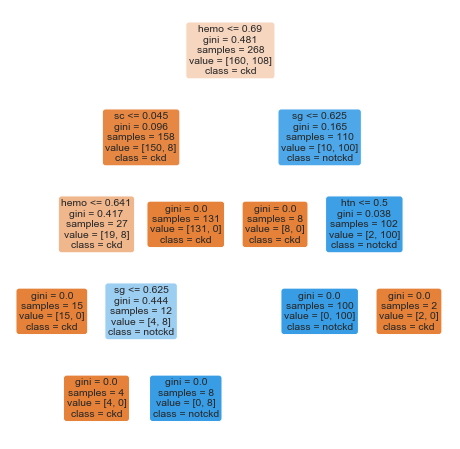

In [819]:
plt.figure(figsize = (8,8))
print(tree.plot_tree(dt, feature_names = X_train.columns, class_names = ['ckd', 'notckd'], filled = True, rounded = True))

In [820]:
print('Decision Tree AUC:', roc_auc_score(y_test, dt_pred))
roc_scores = []
roc_scores.append(roc_auc_score(y_test, dt_pred))

Decision Tree AUC: 0.965079365079365


In [821]:
wrong_predictions = pd.DataFrame(dt_pred, columns = ['is_same']).apply(lambda x : x == y_test)   
dt_pred = pd.Series(dt_pred)
wrong_pedictions = pd.concat([wrong_predictions, dt_pred, y_test], axis = 1)

In [822]:
wrong_predictions[wrong_predictions['is_same'] == False] 

,is_same
79,False
89,False
90,False
122,False


<h3>5B. RANDOM FOREST:</h3>

In [823]:
rfc = RandomForestClassifier(random_state = 1)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
print('Random Forest')
print(confusion_matrix(y_test, rfc_pred))
print(classification_report(y_test, rfc_pred))

Random Forest
[[89  1]
 [ 0 42]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        90
           1       0.98      1.00      0.99        42

    accuracy                           0.99       132
   macro avg       0.99      0.99      0.99       132
weighted avg       0.99      0.99      0.99       132



In [824]:
# parameters={'n_estimators' : range(20,200, 10), 'max_features' : range(2,8,1), 'max_samples' : [0.5], 'random_state' : [1]}
# grid=GridSearchCV(rfc,parameters, verbose = 3, cv = 5)
# grid.fit(X_train,y_train) 
# print(grid.best_estimator_)
# print(grid.best_params_)
# y_pred = grid.predict(X_test)
# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred)) 


Hyperparameter tuning did not change the performance for Random Forest

Random Forest
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        90
           1       0.98      1.00      0.99        42

    accuracy                           0.99       132
   macro avg       0.99      0.99      0.99       132
weighted avg       0.99      0.99      0.99       132



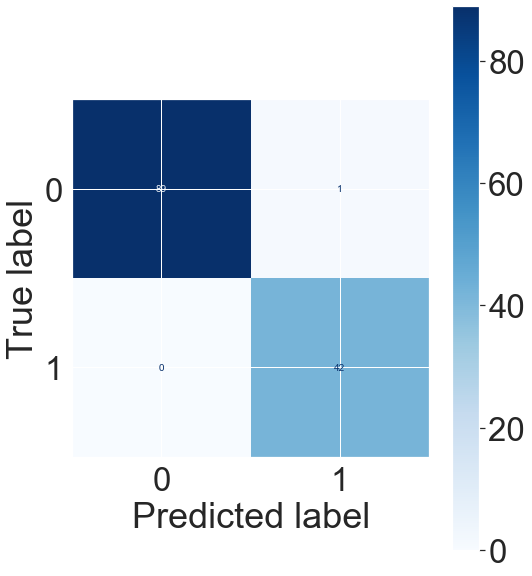

In [825]:
rfc = RandomForestClassifier(n_estimators= 90, max_features = 2, max_samples = 0.5, random_state = 1)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
print('Random Forest')
disp = plot_confusion_matrix(rfc, X_test, y_test,cmap= plt.cm.Blues)
#sns.set(font_scale=3.0)
print(classification_report(y_test, rfc_pred))

In [826]:
wrong_predictions = pd.DataFrame(rfc_pred, columns = ['is_same']).apply(lambda x : x == y_test)   
rfc_pred = pd.Series(rfc_pred)
wrong_pedictions = pd.concat([wrong_predictions, rfc_pred, y_test], axis = 1)

In [827]:
wrong_predictions[wrong_predictions['is_same'] == False] 

,is_same
79,False


In [828]:
print('Random Forest AUC:', roc_auc_score(y_test, rfc_pred))
roc_scores.append(roc_auc_score(y_test, rfc_pred))

Random Forest AUC: 0.9944444444444445


<h3>5C. SUPPORT VECTOR MACHINE</h3>

In [829]:
svc = SVC()
svc.fit(X_train, y_train)
svm_pred = svc.predict(X_test)
print(confusion_matrix(y_test, svm_pred))
print(classification_report(y_test, svm_pred))

[[87  3]
 [ 0 42]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        90
           1       0.93      1.00      0.97        42

    accuracy                           0.98       132
   macro avg       0.97      0.98      0.97       132
weighted avg       0.98      0.98      0.98       132



In [830]:
# params_grid = {'C':[0.1,1,10,100,1000], 'gamma' : [1,0.1,0.01, 0.001, 0.0001], 'kernel' : ['linear', 'rbf','poly']}
# grid = GridSearchCV(svc, params_grid, verbose = 3, cv = 5)
# grid.fit(X_train, y_train)
# print(grid.best_estimator_)
# print(grid.best_params_)
# grid_predictions = grid.predict(X_test)
# print(confusion_matrix(y_test, grid_predictions))
# print(classification_report(y_test, grid_predictions))

Hyperparameter tuning improved accuracy from 97% to 99%. This is because kernel = 'rbf' is the best kernel for this dataset. 

In [831]:
svc = SVC(C=100, gamma=1, kernel='rbf')
svc.fit(X_train, y_train)
svm_pred = svc.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        90
           1       0.95      1.00      0.98        42

    accuracy                           0.98       132
   macro avg       0.98      0.99      0.98       132
weighted avg       0.99      0.98      0.98       132



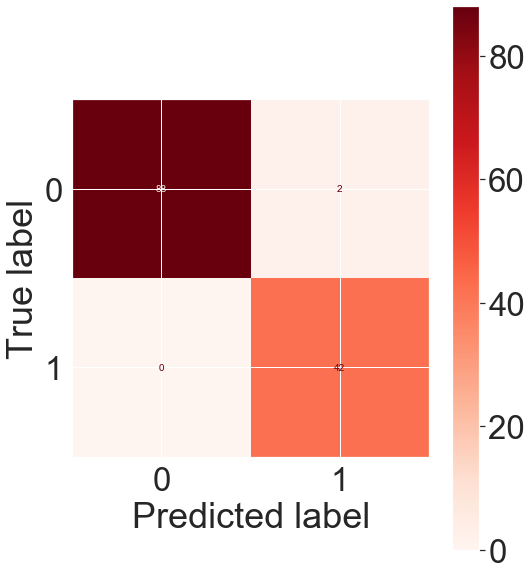

In [832]:
#sns.set(font_scale=3.0)
disp = plot_confusion_matrix(svc, X_test, y_test,cmap= plt.cm.Reds)
print(classification_report(y_test, svm_pred))

In [833]:
wrong_predictions = pd.DataFrame(svm_pred, columns = ['is_same']).apply(lambda x : x == y_test)   

In [834]:
wrong_predictions[wrong_predictions['is_same'] == False] 

,is_same
68,False
104,False


In [835]:
print('SVM AUC:', roc_auc_score(y_test, svm_pred))
roc_scores.append(roc_auc_score(y_test, svm_pred))

SVM AUC: 0.9888888888888888


<h3>5D. NEURAL NETWORKS</h3>

In [836]:
tf.keras.backend.set_floatx('float64')

In [837]:
model = Sequential()

model.add(Dense(units = 8, activation = 'relu'))
model.add(Dense(units = 4, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

In [ ]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=1000,
          validation_data=(X_test, y_test), verbose=1
          )

Epoch 1/1000
9/9 [==============================] - 0s 12ms/step - loss: 0.6024 - val_loss: 0.5739
Epoch 2/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.5768 - val_loss: 0.5483
Epoch 3/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.5496 - val_loss: 0.5248
Epoch 4/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.5387 - val_loss: 0.5027
Epoch 5/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.5182 - val_loss: 0.4842
Epoch 6/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.4997 - val_loss: 0.4680
Epoch 7/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.4900 - val_loss: 0.4526
Epoch 8/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.4736 - val_loss: 0.4384
Epoch 9/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.4679 - val_loss: 0.4247
Epoch 10/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4561 - val_loss: 0.4116
Epoch 11/1000
9/9 

Epoch 84/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.0774 - val_loss: 0.1056
Epoch 85/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.0698 - val_loss: 0.1020
Epoch 86/1000
9/9 [==============================] - 0s 12ms/step - loss: 0.0852 - val_loss: 0.1024
Epoch 87/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.0758 - val_loss: 0.0985
Epoch 88/1000
9/9 [==============================] - 0s 28ms/step - loss: 0.0658 - val_loss: 0.0973
Epoch 89/1000
9/9 [==============================] - 0s 26ms/step - loss: 0.0664 - val_loss: 0.0985
Epoch 90/1000
9/9 [==============================] - 0s 22ms/step - loss: 0.0633 - val_loss: 0.0976
Epoch 91/1000
9/9 [==============================] - 0s 29ms/step - loss: 0.0690 - val_loss: 0.0983
Epoch 92/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.0643 - val_loss: 0.0966
Epoch 93/1000
9/9 [==============================] - 0s 12ms/step - loss: 0.0580 - val_loss: 0.0944
Ep

9/9 [==============================] - 0s 22ms/step - loss: 0.0310 - val_loss: 0.0570
Epoch 166/1000
9/9 [==============================] - 0s 12ms/step - loss: 0.0308 - val_loss: 0.0582
Epoch 167/1000
9/9 [==============================] - 0s 23ms/step - loss: 0.0339 - val_loss: 0.0577
Epoch 168/1000
9/9 [==============================] - 0s 18ms/step - loss: 0.0303 - val_loss: 0.0557
Epoch 169/1000
9/9 [==============================] - 0s 31ms/step - loss: 0.0303 - val_loss: 0.0534
Epoch 170/1000
9/9 [==============================] - 0s 15ms/step - loss: 0.0324 - val_loss: 0.0542
Epoch 171/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0304 - val_loss: 0.0526
Epoch 172/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.0296 - val_loss: 0.0535
Epoch 173/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0313 - val_loss: 0.0526
Epoch 174/1000
9/9 [==============================] - 0s 13ms/step - loss: 0.0297 - val_loss: 0.0544
Epoch

9/9 [==============================] - 0s 6ms/step - loss: 0.0206 - val_loss: 0.0358
Epoch 247/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.0224 - val_loss: 0.0356
Epoch 248/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.0294 - val_loss: 0.0349
Epoch 249/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.0206 - val_loss: 0.0325
Epoch 250/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.0242 - val_loss: 0.0323
Epoch 251/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.0204 - val_loss: 0.0339
Epoch 252/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.0223 - val_loss: 0.0365
Epoch 253/1000
9/9 [==============================] - 0s 8ms/step - loss: 0.0201 - val_loss: 0.0355
Epoch 254/1000
9/9 [==============================] - 0s 13ms/step - loss: 0.0202 - val_loss: 0.0351
Epoch 255/1000
9/9 [==============================] - 0s 15ms/step - loss: 0.0210 - val_loss: 0.0333
Epoch 256/100

9/9 [==============================] - 0s 14ms/step - loss: 0.0167 - val_loss: 0.0251
Epoch 328/1000
9/9 [==============================] - 0s 10ms/step - loss: 0.0158 - val_loss: 0.0242
Epoch 329/1000
9/9 [==============================] - 0s 8ms/step - loss: 0.0179 - val_loss: 0.0241
Epoch 330/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.0157 - val_loss: 0.0251
Epoch 331/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.0202 - val_loss: 0.0245
Epoch 332/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.0156 - val_loss: 0.0248
Epoch 333/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.0168 - val_loss: 0.0251
Epoch 334/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.0156 - val_loss: 0.0250
Epoch 335/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.0156 - val_loss: 0.0237
Epoch 336/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.0154 - val_loss: 0.0235
Epoch 337/100

9/9 [==============================] - 0s 5ms/step - loss: 0.0133 - val_loss: 0.0173
Epoch 410/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.0127 - val_loss: 0.0174
Epoch 411/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.0129 - val_loss: 0.0170
Epoch 412/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.0125 - val_loss: 0.0171
Epoch 413/1000
9/9 [==============================] - 0s 9ms/step - loss: 0.0126 - val_loss: 0.0172
Epoch 414/1000
9/9 [==============================] - 0s 10ms/step - loss: 0.0124 - val_loss: 0.0169
Epoch 415/1000
9/9 [==============================] - 0s 9ms/step - loss: 0.0201 - val_loss: 0.0170
Epoch 416/1000
9/9 [==============================] - 0s 12ms/step - loss: 0.0126 - val_loss: 0.0156
Epoch 417/1000
9/9 [==============================] - 0s 9ms/step - loss: 0.0129 - val_loss: 0.0153
Epoch 418/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.0126 - val_loss: 0.0155
Epoch 419/100

Epoch 491/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0125
Epoch 492/1000
9/9 [==============================] - 0s 9ms/step - loss: 0.0103 - val_loss: 0.0128
Epoch 493/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.0102 - val_loss: 0.0126
Epoch 494/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0125
Epoch 495/1000
9/9 [==============================] - 0s 10ms/step - loss: 0.0102 - val_loss: 0.0123
Epoch 496/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.0114 - val_loss: 0.0118
Epoch 497/1000
9/9 [==============================] - 0s 8ms/step - loss: 0.0101 - val_loss: 0.0119
Epoch 498/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0116
Epoch 499/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.0102 - val_loss: 0.0123
Epoch 500/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0123

Epoch 573/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.0085 - val_loss: 0.0094
Epoch 574/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.0088 - val_loss: 0.0090
Epoch 575/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.0136 - val_loss: 0.0091
Epoch 576/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.0082 - val_loss: 0.0084
Epoch 577/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.0084 - val_loss: 0.0083
Epoch 578/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.0085 - val_loss: 0.0085
Epoch 579/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.0083 - val_loss: 0.0086
Epoch 580/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.0083 - val_loss: 0.0089
Epoch 581/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.0082 - val_loss: 0.0089
Epoch 582/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.0089 - val_loss: 0.0091


Epoch 655/1000
9/9 [==============================] - 0s 10ms/step - loss: 0.0065 - val_loss: 0.0066
Epoch 656/1000
9/9 [==============================] - 0s 9ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 657/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.0071 - val_loss: 0.0064
Epoch 658/1000
9/9 [==============================] - 0s 8ms/step - loss: 0.0068 - val_loss: 0.0066
Epoch 659/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 660/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 661/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.0067 - val_loss: 0.0069
Epoch 662/1000
9/9 [==============================] - 0s 13ms/step - loss: 0.0067 - val_loss: 0.0067
Epoch 663/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.0067 - val_loss: 0.0068
Epoch 664/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.0068 - val_loss: 0.00

In [ ]:
model_loss = pd.DataFrame(model.history.history)

In [ ]:
model_loss.plot()

<h4>We can see here that overfitting is happening because number of epochs was too large. I will improve this by using Early Stopping and Dropout Layers</h4>

<h5>Early Stopping:</h5>

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
#Patience -> the number of epochs to wait before early stop if no progress on the validation set.

In [ ]:
model = Sequential()

model.add(Dense(units = 8, activation = 'relu'))
model.add(Dense(units = 4, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

In [ ]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=1000,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

In [ ]:
model_loss = pd.DataFrame(model.history.history)

In [ ]:
model_loss.plot()

<h5> Dropout </h5>

The model with the best weights were saved and restored~

In [ ]:
model = Sequential()

model.add(Dense(units = 8, activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(units = 4, activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(units = 1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics = 'accuracy')

model.load_weights('./checkpoints/my_checkpoint')

In [ ]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=1000,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

#model.save_weights('./checkpoints/my_checkpoint')

In [ ]:
nn_pred = model.predict_classes(X_test)

In [ ]:
print(confusion_matrix(y_test,nn_pred))
print(classification_report(y_test,nn_pred))

In [ ]:
wrong_predictions = pd.DataFrame(nn_pred, columns = ['is_same']).apply(lambda x : x == y_test)  

In [ ]:
wrong_predictions[wrong_predictions['is_same'] == False] 

In [ ]:
print('Neural Networks AUC:', roc_auc_score(y_test, nn_pred))
roc_scores.append(roc_auc_score(y_test, nn_pred))

<h3> 5E. HYBRID MODEL </h3>

In [ ]:
n_train = df_train.shape[0]
n_test = df_test.shape[0]
n_splits = 5
seed = 0
kfold = KFold(n_splits= n_splits, random_state= seed, shuffle = True)

In [ ]:
def get_out_of_folds(clf, x_train, y_train, x_test):
    '''
        Creates predictions of base classifiers that are later used as input for training to meta classifier
    '''
    oof_train = np.zeros((n_train,))
    oof_test = np.zeros((n_test,))
    oof_test_skf = np.empty((n_splits, n_test))

    for i, (train_index, test_index) in enumerate(kfold.split(X_train)):
        x_tr = X_train.iloc[train_index]
        y_tr = y_train.iloc[train_index]
        x_te = X_train.iloc[test_index]
        #print(i, train_index, test_index)
        clf.fit(x_tr, y_tr)#fit using 4 folds(224 records) + based on 10 features in X_train

        oof_train[test_index] = clf.predict_proba(x_te)[:,1]#predict 5th fold based on the 10 features 
        oof_test_skf[i, :] = clf.predict_proba(x_test)[:,1]#predict X_test 5 times (kfold = 5) and take mean (also 10 features)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)
    #oof_train has predictions for all 280 records in X_train and oof_test has predictions for 120 records in X_test

In [ ]:
#Create Base Models
#Seed to ensure that output doesn't vary from run to run

rf = RandomForestClassifier(random_state = seed)
log = LogisticRegression(random_state = seed)
nb = GaussianNB()

In [ ]:
rf_oof_train, rf_oof_test = get_out_of_folds(rf, X_train, y_train, X_test)
log_oof_train, log_oof_test = get_out_of_folds(log, X_train, y_train, X_test)
nb_oof_train, nb_oof_test = get_out_of_folds(nb, X_train, y_train, X_test)

In [ ]:
base_predictions_train = pd.DataFrame( {
                                        'RandomForest': rf_oof_train.ravel(),
                                        'LOG': log_oof_train.ravel(),
                                        'NB': nb_oof_train.ravel(),
                                     })
base_predictions_train.head()

In [ ]:
sns.heatmap(base_predictions_train.corr())

It is better to have high performing but uncorrelated models in a hybrid model. Highly correlated models give no useful information since they just pass and fail in the diagnosis of the same records~

In [ ]:
hybrid_train = np.concatenate((rf_oof_train, log_oof_train, nb_oof_train), axis=1)
hybrid_test = np.concatenate(( rf_oof_test, log_oof_test, nb_oof_test), axis=1)

In [ ]:
nb = GaussianNB().fit(hybrid_train, y_train)
hybrid_pred = nb.predict(hybrid_test)

In [ ]:
disp = plot_confusion_matrix(nb, hybrid_test, y_test,cmap= plt.cm.Blues)

In [ ]:
print(classification_report(hybrid_pred.round(), y_test))

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, dt_pred)
plt.plot(fpr,tpr, label = 'Decision Tree, AUC:' + str(round(roc_auc_score(y_test, dt_pred),3)))
fpr, tpr, thresholds = roc_curve(y_test, rfc_pred)
plt.plot(fpr,tpr, label = 'Random Forest, AUC:' + str(round(roc_auc_score(y_test, rfc_pred),3)))
fpr, tpr, thresholds = roc_curve(y_test, svm_pred)
plt.plot(fpr,tpr,  label = 'SVM, AUC:' +  str(round(roc_auc_score(y_test, svm_pred),3)))
fpr, tpr, thresholds = roc_curve(y_test, nn_pred)
plt.plot(fpr,tpr,  label = 'Artificial Neural Network, AUC:' + str(round(roc_auc_score(y_test, nn_pred),3)))
fpr, tpr, thresholds = roc_curve(y_test, hybrid_pred)
plt.plot(fpr,tpr,  label = 'Hybrid Model, AUC:' + str(round(roc_auc_score(y_test, hybrid_pred),3)))

# Print ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Diagram')
plt.legend(loc="lower right")
plt.legend(loc="lower right")
plt.show() 

<h2> 5F. CLUSTERING </h2>

<h3>1. K-Means Clustering</h3>


In [ ]:
whole_df = pd.concat([X_tr_cluster, X_te_cluster]).reset_index(drop = True)

In [ ]:
pca = PCA(n_components=2)
pca.fit(whole_df)
pca_res = pca.transform(whole_df)

In [ ]:
pca_df = pd.DataFrame(pca_res)

In [ ]:
predictions_train = pd.Series(y_train)
predictions_test = pd.Series(y_test)

predictions = pd.concat([predictions_train, predictions_test]).reset_index(drop = True)
predictions.columns = 'class'

In [ ]:
cluster_df = pd.concat([pca_df, predictions], axis = 1)
cluster_df = cluster_df[cluster_df['class'] == 0]
cluster_df = cluster_df.drop('class', axis = 1)
cluster_df = cluster_df.reset_index(drop = True)

In [ ]:
print(cluster_df.head())

In [ ]:
kmeans = KMeans(n_clusters = 6) 
y_kmeans = kmeans.fit_predict(cluster_df)

In [ ]:
plt.figure(figsize = (10,10))
plt.scatter(cluster_df.iloc[:,0], cluster_df.iloc[:,1], c = kmeans.labels_, cmap = 'rainbow')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

<h3> 2. Hierarchical Clustering </h3>

In [ ]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(cluster_df, method='complete'))
plt.axhline(y=0.75, color='r', linestyle='--')

In [ ]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters= 6, affinity='hamming', linkage='complete')  
cluster.fit_predict(cluster_df)

In [ ]:
cluster_df.head(12)

In [ ]:
plt.figure(figsize = (10,10))
plt.scatter(cluster_df.iloc[:,0], cluster_df.iloc[:,1], c = cluster.labels_, cmap = 'rainbow')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

In [ ]:
hierarchical_labels = pd.Series(cluster.labels_, name = 'cluster_labels')

In [ ]:
whole_df_unscaled = pd.concat([X_train_copy, X_test_copy]).reset_index(drop = True)

In [ ]:
whole_df_unscaled = pd.concat([whole_df_unscaled, predictions], axis = 1)

In [ ]:
whole_df_unscaled = whole_df_unscaled[whole_df_unscaled['class'] == 0]
whole_df_unscaled = whole_df_unscaled.drop('class', axis = 1)
whole_df_unscaled = whole_df_unscaled.reset_index(drop = True)

In [ ]:
whole_df_unscaled = pd.concat([whole_df_unscaled, hierarchical_labels], axis = 1)

In [ ]:
whole_df_unscaled['rbc'] = whole_df_unscaled['rbc'].map({0: 'normal', 1 : 'abnormal'})
whole_df_unscaled['pc'] = whole_df_unscaled['pc'].map({0 : 'normal', 1 : 'abnormal'})
whole_df_unscaled['pcc'] = whole_df_unscaled['pcc'].map({0 : 'notpresent', 1 : 'present'})
whole_df_unscaled['ba'] = whole_df_unscaled['ba'].map({0 : 'notpresent', 1 : 'present'})
whole_df_unscaled['htn'] = whole_df_unscaled['htn'].map({0 : 'no', 1 : 'yes'})
whole_df_unscaled['dm'] = whole_df_unscaled['dm'].map({0 : 'no', 1 : 'yes'})
whole_df_unscaled['cad'] = whole_df_unscaled['cad'].map({0 : 'no', 1 : 'yes'})
whole_df_unscaled['pe'] = whole_df_unscaled['pe'].map({ 0 : 'no', 1 : 'yes'})
whole_df_unscaled['ane'] = whole_df_unscaled['ane'].map({0 : 'no', 1 : 'yes'})
whole_df_unscaled['appet'] = whole_df_unscaled['appet'].map({0 : 'good', 1 : 'poor'})
#whole_df_unscaled['class'] = whole_df_unscaled['class'].map({0 : 'ckd', 1 : 'notckd'})

In [ ]:
whole_df_unscaled.columns = ['age', 'blood pressure in mm/Hg', 'Specific Gravity (nominal)','Albumin(nominal)','Sugar (nominal)', 'Red Blood Cells', 'Pus Cell', 'Puc Cell Clumps', 'Bacteria', 'Blood Glucose Random in mgs/dl', 'Blood Urea in mgs/dl', 'Serum Creatinine in mgs/dl', 'Sodium in mEq/L', 'Potassium in mEq\L', 'Hemoglobin in gms', 'Packed Cell Volume', 'White Blood Cell count /cumm', 'Red Blood Cell Count /cmm', 'Hypertension', 'Diabetes', 'Coronary Artery Disease', 'Appetite', 'Pedal Enema', 'Anemia', 'cluster_labels']



In [ ]:
def find_female_gfr(df):
    gfrs= []
    for row in df.iterrows():
        age = float(row[1]['age'])
        sc = float(row[1]['Serum Creatinine in mgs/dl'])
        if sc <= 0.7:
            C = -0.329
        elif sc > 0.7:
            C = -1.209
        gfr = np.round(144 * ((sc/0.7) ** C) * (0.993 ** age),0)
        #print(((sc/0.7) ** C) * 144 * (0.993 ** age))
        if gfr >= 90:
            gfrs.append('1')
        elif gfr >= 60 and gfr <= 89:
            gfrs.append('2')
        elif gfr >= 45 and gfr <= 59:
            gfrs.append('3a')
        elif gfr >= 30 and gfr <= 44:
            gfrs.append('3b')
        elif gfr >= 15 and gfr <= 29:
            gfrs.append('4')
        elif gfr < 15:
            gfrs.append('5')
    return gfrs

In [ ]:
def find_male_gfr(df):
    gfrs= []
    for row in df.iterrows():
        age = float(row[1]['age'])
        sc = float(row[1]['Serum Creatinine in mgs/dl'])
        if sc <= 0.9:
            C = -0.411
        elif sc > 0.9:
            C = -1.209
        gfr = np.round(141 * ((sc/0.9) ** C) * (0.993 ** age),0)
        if gfr >= 90:
            gfrs.append('1')
        elif gfr >= 60 and gfr <= 89:
            gfrs.append('2')
        elif gfr >= 45 and gfr <= 59:
            gfrs.append('3a')
        elif gfr >= 30 and gfr <= 44:
            gfrs.append('3b')
        elif gfr >= 15 and gfr <= 29:
            gfrs.append('4')
        elif gfr < 15:
            gfrs.append('5')
    return gfrs

In [ ]:
len(find_male_gfr(Stage_a))

In [ ]:
Stage_a = whole_df_unscaled[whole_df_unscaled['cluster_labels'] == 0].drop('cluster_labels', axis = 1)
Stage_a = Stage_a.reset_index(drop = True)

Stage_a['male_gfr'] = find_male_gfr(Stage_a)
Stage_a['female_gfr'] = find_female_gfr(Stage_a)
Stage_a.to_csv('Stage_a.csv')

print(Stage_a['male_gfr'].value_counts())
print(Stage_a['female_gfr'].value_counts())

print(Stage_a.mean())

#Later stage

In [ ]:
Stage_b = whole_df_unscaled[whole_df_unscaled['cluster_labels'] == 1].drop('cluster_labels', axis = 1)
Stage_b = Stage_b.reset_index(drop = True)

Stage_b['male_gfr'] = find_male_gfr(Stage_b)
Stage_b['female_gfr'] = find_female_gfr(Stage_b)

Stage_b.to_csv('Stage_b.csv')

print(Stage_b['male_gfr'].value_counts())
print(Stage_b['female_gfr'].value_counts())

print(Stage_b.mean())
#Later stage

In [ ]:
Stage_c = whole_df_unscaled[whole_df_unscaled['cluster_labels'] == 2].drop('cluster_labels', axis = 1)
Stage_c = Stage_c.reset_index(drop = True)

Stage_c['male_gfr'] = find_male_gfr(Stage_c)
Stage_c['female_gfr'] = find_female_gfr(Stage_c)

Stage_c.to_csv('Stage_c.csv')

print(Stage_c['male_gfr'].value_counts())
print(Stage_c['female_gfr'].value_counts())

print(Stage_c.mean())

print(Stage_c['Appetite'].value_counts())
#Later stage

In [ ]:
Stage_d = whole_df_unscaled[whole_df_unscaled['cluster_labels'] == 3].drop('cluster_labels', axis = 1)
Stage_d = Stage_d.reset_index(drop = True)

Stage_d['male_gfr'] = find_male_gfr(Stage_d)
Stage_d['female_gfr'] = find_female_gfr(Stage_d)

Stage_d.to_csv('Stage_d.csv')

print(Stage_d['male_gfr'].value_counts())
print(Stage_d['female_gfr'].value_counts())

print(Stage_d.mean())
#Earlier Stage

In [ ]:
Stage_e = whole_df_unscaled[whole_df_unscaled['cluster_labels'] == 4].drop('cluster_labels', axis = 1)
Stage_e = Stage_e.reset_index(drop = True)

Stage_e['male_gfr'] = find_male_gfr(Stage_e)
Stage_e['female_gfr'] = find_female_gfr(Stage_e)

Stage_e.to_csv('Stage_e.csv')

print(Stage_e['male_gfr'].value_counts())
print(Stage_e['female_gfr'].value_counts())

print(Stage_e.mean())

In [ ]:
Stage_f = whole_df_unscaled[whole_df_unscaled['cluster_labels'] == 5].drop('cluster_labels', axis = 1)
Stage_f = Stage_f.reset_index(drop = True)

Stage_f['male_gfr'] = find_male_gfr(Stage_f)
Stage_f['female_gfr'] = find_female_gfr(Stage_f)

Stage_f.to_csv('Stage_f.csv')

print(Stage_f['male_gfr'].value_counts())
print(Stage_f['female_gfr'].value_counts())

print(Stage_f.mean())


<h2> 5G. SELF ORGANIZING MAP </h2>

In [ ]:
from sompy.sompy import SOMFactory

sm = SOMFactory().build(cluster_df.to_numpy(), initialization='pca', component_names= ['Self Organizing Map','Self Organizing Map'], lattice = 'hexa', mapsize = [50,50])
sm.train(n_job=1, verbose=False, train_rough_len=10, train_finetune_len=10)

In [ ]:
topographic_error = sm.calculate_topographic_error()
quantization_error = sm.calculate_quantization_error()
print ("Topographic error = %s; Quantization error = %s" % (topographic_error, quantization_error))

In [ ]:
from sompy.visualization.mapview import View2D
view2D  = View2D(5,5,"",text_size=10)
view2D.show(sm, col_sz= 1, which_dim="all", denormalize=False)